In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [47]:
### define initial values
n_years = 100
dt = 1/12
n_factors = 5
n_trials = 10000

#inflation
lambda_rate = 0.1277  # Rate of jumps
mu_J = 0.0040  # Mean of jump sizes
sigma_J = 0.0137  # Standard deviation of jump sizes
m = lambda_rate*(np.exp(mu_J + sigma_J**2/2)-1)

In [27]:
#generate normal random samples, of dimension (2,1200,10000)
X = np.random.standard_normal((n_factors,int(n_years*1/dt),n_trials))
corre_mat = np.array([[1,-0.7,0.7,-0.5,0],
                      [-0.7,1,-0.5,0.8,0],
                      [0.7,-0.5,1,-0.6,0],
                      [-0.5,0.8,-0.6,1,0],
                      [0,0,0,0,1]  
                     ])
L = np.linalg.cholesky(corre_mat)
correlateWeinerProcess = np.sqrt(dt)*(np.einsum('ij,ikl -> ikl',L,X))

In [29]:
#initial conditions
x = np.zeros((n_factors,int(n_years*1/dt),n_trials))
x[0,:,:] = 0.0228
x[1,:,:] = 0.0809
x[2,:,:] = 0.0001 ## volatility
x[3,:,:] = 0
x[4,:,:] = 0


mu = np.zeros((n_factors,int(n_years*1/dt),n_trials))
mu[0,:,:] = 0.0546
mu[1,:,:] = 0.0778
mu[2,:,:] = 0.0001 ## volatility
mu[3,:,:] = 0
mu[4,:,:] = 0

sigma = np.zeros((n_factors,int(n_years*1/dt),n_trials))
sigma[0,:,:] = 0.0412
sigma[1,:,:] = 0.0287
sigma[2,:,:] = 0.0140  ## volatility
sigma[3,:,:] = 0.0200
sigma[4,:,:] = 0.0090



alpha = np.zeros((n_factors,int(n_years*1/dt),n_trials))
alpha[0,:,:] = 1.0682
alpha[1,:,:] = 0.0469
alpha[2,:,:] = 0.8687 ## volatility
alpha[3,:,:] = 0.2000   
alpha[4,:,:] = 0.0480


In [32]:
for i in range(int(n_years/dt)-1):
    dzt = correlateWeinerProcess[:,i,:]
    xt = x[:,i,:]
    drift = np.einsum(',ij->ij',dt,np.einsum('ij,ij -> ij', alpha[:,i,:], (mu[:,i,:]-xt)))
    
    diffusion_n_v = np.einsum('ij,ij->ij',np.einsum('ij,ij->ij',sigma[:3,i,:],np.sqrt(np.maximum(0,xt[:3,:]))),dzt[:3,:])
    diffusion_r = np.einsum('ij,ij->ij',sigma[3:,i,:],dzt[3:,:])
    x[:3,i+1,:] = xt[:3,:]+drift[:3,:]+diffusion_n_v
    x[3:,i+1,:] = xt[3:,:]+drift[3:,:]+diffusion_r

In [41]:
final_x_nominal = x[:2,:,:]
phi = -0.0587
xt_nominal=np.sum(final_x_nominal,axis=0)
n = (phi + xt_nominal)


final_x_real = x[3:,:,:]
psi=0.02
xt_real=np.sum(final_x_real,axis=0)
r = (psi + xt_real)

v = x[2,:,:]
v[v<0] = 0

In [48]:
# Initialize I(t) array
I = np.zeros((int(n_years*1/dt), n_trials))
I[0, :] = 1  # Initial condition for I(t), set all trials to start from 100

# Simulation
for t in range(1, int(n_years*1/dt)):
    # Number of jumps in each trial at step t
    n_J = np.random.poisson(lambda_rate * dt, n_trials)

    # Brownian increments
    delta_Z = np.random.normal(0, np.sqrt(dt), n_trials)
    
    # Standard normal for jump diffusion
    Z_J = np.random.normal(0, 1, n_trials)  

    # Update I(t)
    I[t, :] = I[t-1, :] * np.exp(
        (n[t-1, :] - r[t-1, :] - 0.5 * v[t-1, :] - m) * dt
        + np.sqrt(v[t-1, :]) * delta_Z
        + n_J * mu_J + np.sqrt(n_J) * sigma_J * Z_J
    )



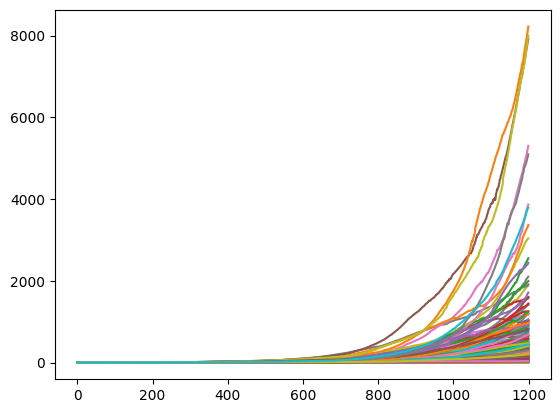

In [50]:
for i in range(200):
    plt.plot(I[:,i])

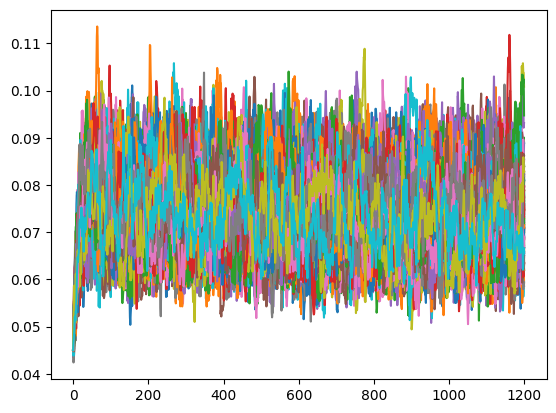

In [42]:
for i in range(200):
    plt.plot(n[:,i])

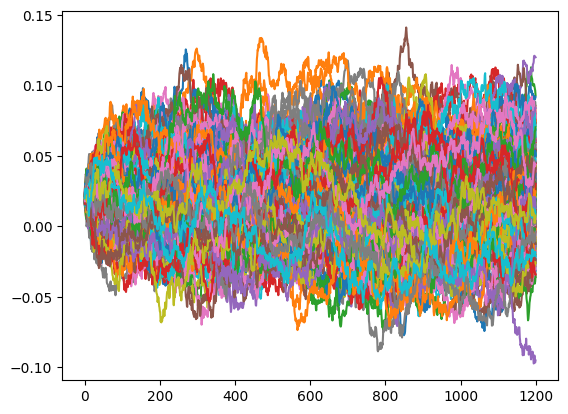

In [43]:
for i in range(200):
    plt.plot(r[:,i])

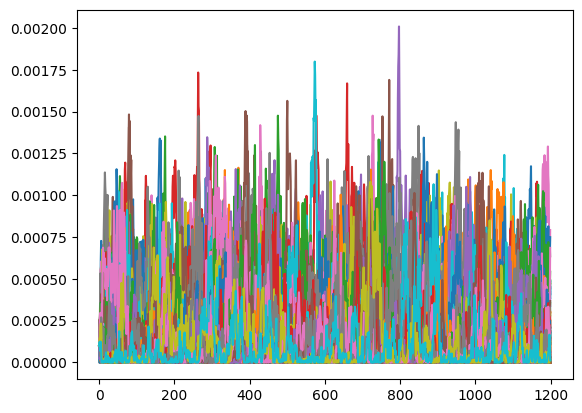

In [44]:
for i in range(200):
    plt.plot(v[:,i])